In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import sqlite3
import seaborn as sns
import polars as pl

from py_utilities.__init__ import format_yticks, print_corr_matrix, shapiro_wilk_and_bartlett_tests

db_folder = "data/raw_data/"
df_folder = "data/clean_data"
db_filename = "database.sqlite"

# Construct the relative file path
db_path = os.path.join(db_folder, db_filename)



Invoking __init__.py for py_utilities
Invoking __init__.py for py_utilities.__init__


In [2]:
import duckdb
duckdb.sql("LOAD sqlite;")

In [3]:
# Some plot styling preferences
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 14}

# Set styles for plots
qualitative_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

palette = 'crest'
style = 'darkgrid'

font = {'family': 'serif', 'size': 12}

# Set seaborn palette and style
sns.set(palette=palette, style=style, font=font)
plt.rc('font', **font)

In [4]:
conn = sqlite3.connect(db_path)
con = duckdb.connect(db_folder + db_filename)

In [5]:
# Check the available tables
tables = pd.read_sql("""
    SELECT * FROM sqlite_master 
    WHERE TYPE = 'table' """,conn)

for row in tables["sql"]:
    print(row)

CREATE TABLE runs (
        run_at text not null,
        max_rowid integer not null,
        reviews_added integer not null
    )
CREATE TABLE podcasts (
        podcast_id text primary key,
        itunes_id integer not null,
        slug text not null,
        itunes_url text not null,
        title text not null
    )
CREATE TABLE categories (
        podcast_id text not null,
        category text not null
    )
CREATE TABLE reviews (
        podcast_id text not null,
        title text not null,
        content text not null,
        rating integer not null,
        author_id text not null,
        created_at text not null
    )


In [6]:
con.sql("SELECT COUNT(*) as number_of_podcasts FROM podcasts")

┌────────────────────┐
│ number_of_podcasts │
│       int64        │
├────────────────────┤
│             110024 │
└────────────────────┘

In [7]:
con.sql('SELECT * FROM categories')

┌──────────────────────────────────┬──────────────────────┐
│            podcast_id            │       category       │
│             varchar              │       varchar        │
├──────────────────────────────────┼──────────────────────┤
│ c61aa81c9b929a66f0c1db6cbe5d8548 │ arts                 │
│ c61aa81c9b929a66f0c1db6cbe5d8548 │ arts-performing-arts │
│ c61aa81c9b929a66f0c1db6cbe5d8548 │ music                │
│ ad4f2bf69c72b8db75978423c25f379e │ arts                 │
│ ad4f2bf69c72b8db75978423c25f379e │ arts-design          │
│ ad4f2bf69c72b8db75978423c25f379e │ education            │
│ ad4f2bf69c72b8db75978423c25f379e │ society-culture      │
│ f2970432aad718a000ebac10e48ae6b0 │ arts                 │
│ f2970432aad718a000ebac10e48ae6b0 │ arts-performing-arts │
│ f2970432aad718a000ebac10e48ae6b0 │ society-culture      │
│                ·                 │        ·             │
│                ·                 │        ·             │
│                ·                 │    

We are going to investigate which podcasts are the most popular and which ones have the highest number of reviews, and their respective categories.

In [8]:
# Check the number of podcasts
con.sql("""
SELECT
   COUNT(*) AS total_podcasts 
FROM
   podcasts;""")

┌────────────────┐
│ total_podcasts │
│     int64      │
├────────────────┤
│         110024 │
└────────────────┘

In [9]:
# Check the number of reviews
con.sql("""
SELECT
   COUNT(*) AS total_reviews 
FROM
   reviews;""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┐
│ total_reviews │
│     int64     │
├───────────────┤
│       2067529 │
└───────────────┘

Let's check the years distribution of our podcasts, when does the dataset start and end?

In [10]:
# Execute the SQL query and fetch the results into a Pandas DataFrame
yearly_reviews = pd.read_sql_query("""
SELECT 
    strftime('%Y', r.created_at) AS year, 
    COUNT(*) AS review_count,
    p.title
FROM reviews r
JOIN podcasts p ON r.podcast_id = p.podcast_id
WHERE year != 'None'
GROUP BY year, p.title
ORDER BY year;
""", conn)

yearly_reviews

,year,review_count,title
0,2005,2,60 Minutes
1,2005,1,Acoustic Long Island
2,2005,2,All Songs Considered
3,2005,1,All Things Media
4,2005,1,Animal Radio®
...,...,...,...
221390,2023,4,不明白播客
221391,2023,15,好味小姐開束縛我還你原形
221392,2023,1,日谈公园
221393,2023,1,이진우의 손에 잡히는 경제


/home/alessio-pc/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/alessio-pc/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/alessio-pc/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


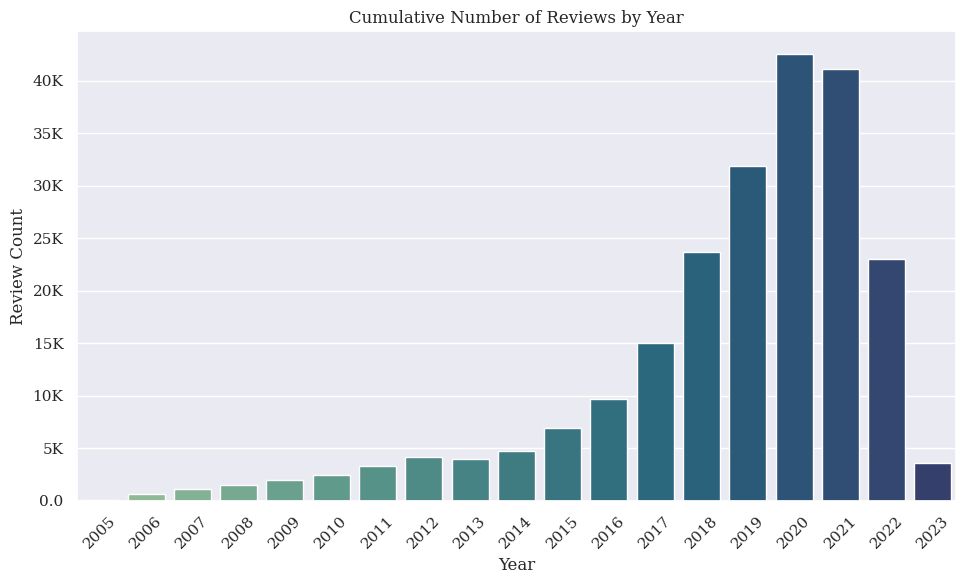

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=yearly_reviews, x='year', palette=palette)
plt.xlabel('Year')
plt.ylabel('Review Count')
plt.title('Cumulative Number of Reviews by Year')
plt.xticks(rotation=45)
plt.tight_layout()

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_yticks))

# Show the plot
plt.show()

The number of reviews kept growing almost exponentially until 2019. We can assume that the number of reviews is a good indicator of popularity. Another factor to consider is the time of the year, due to particular situations such as COVID-19 coming around that time point, there may have been a boom in new podcasts being released, and thus the number of reviews just increased but not the overall popularity of entertainment format.

Unfortunately, we don't have data to corroborate this with the precise date a podcast started, but we can assume the time of the first review to be around the same time.

In [12]:
podcast_start_year = pd.read_sql_query("""
SELECT 
    title,
    author_id,
    rating,
    first_review_year,
    review_count,
    content
FROM (
    SELECT
        p.title,
        r.author_id,
        r.rating,
        strftime('%Y', r.created_at) AS first_review_year, 
        COUNT(*) OVER (PARTITION BY p.title) AS review_count,
        ROW_NUMBER() OVER (PARTITION BY p.title ORDER BY r.created_at) AS row_num,
        r.content
    FROM podcasts p
    LEFT JOIN reviews r ON p.podcast_id = r.podcast_id
    LEFT JOIN categories c ON p.podcast_id = c.podcast_id
) subquery
WHERE row_num = 1
GROUP BY first_review_year, title
ORDER BY first_review_year, title
""", conn)

podcast_start_year

,title,author_id,rating,first_review_year,review_count,content
0,60 Minutes,DCE825C7F45E3A5,2,2005,411,"60 minutes, change the name to podcast 13 minu..."
1,Acoustic Long Island,9BAF929D2ACB2FD,5,2005,32,I Love This Podcast. I live in a rural village...
2,All Songs Considered,BF99560F0BB8F18,4,2005,280,Eclectic middlebrow choices with some surprises.
3,All Things Media,E35F4D5574B781A,5,2005,3,All Things media is the best and funniest podc...
4,Animal Radio®,87F0BF50FBCCE3E,1,2005,15,This is the worst podcast I have listened to w...
...,...,...,...,...,...,...
109269,Where is My Mind?,C654F1E86EC26D2,5,2023,11,"So needed, especially going into the new year!"
109270,Why I Hate It Here,5FBF9063C720BFB,5,2023,6,Eric does a great job of taking the little ann...
109271,"YOUR BIRTH, GOD’S WAY with Lori Morris, CNM, M...",BBF0FBD87BEF2F2,5,2023,44,Lori is a wonderful resource for mama’s seekin...
109272,further than fish,67B866602739E08,5,2023,1,Every time I listen to your beautiful voice my...


/home/alessio-pc/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/alessio-pc/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/alessio-pc/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


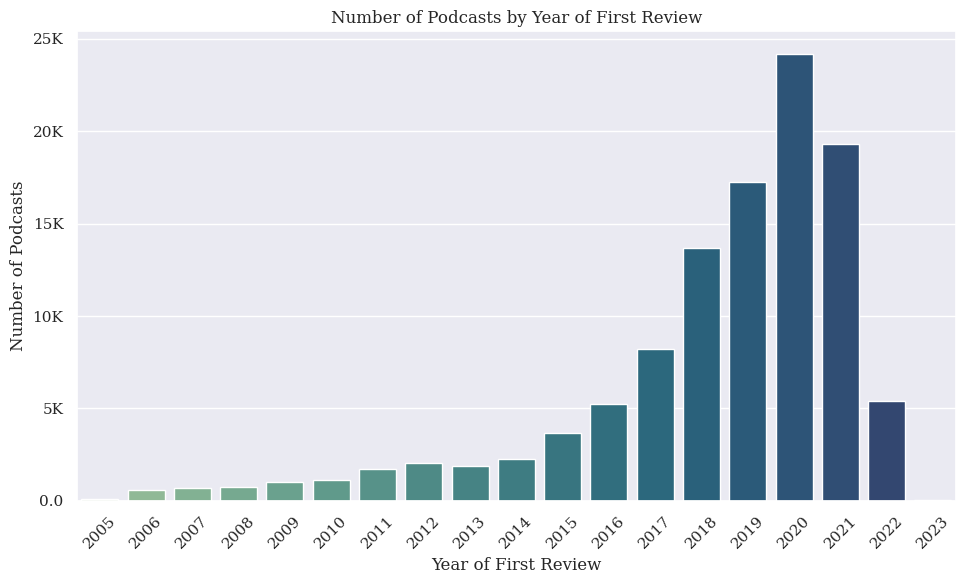

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(data=podcast_start_year, x='first_review_year', palette=palette)
plt.xlabel('Year of First Review')
plt.ylabel('Number of Podcasts')
plt.title('Number of Podcasts by Year of First Review')
plt.xticks(rotation=45)
plt.tight_layout()

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_yticks))

# Show the plot
plt.show()

This graph shows the number of podcasts which received a first review in a certain year. It shows us that, in a sense, the podcast format has indeed grown, and as we hypothesized, much so was during the COVID-19 pandemic in 2020. 

It's hard to compare the number of reviews as a measure of success in this case, as some podcasts have been going on for longer. However, we can check if there are some podcasts which, during the same year, have a higher number of reviews compared to others.

In [14]:
reviews_increase = pd.read_sql_query("""
WITH InitialReviewCounts AS (
    SELECT
        p.title,
        SUM(CASE WHEN strftime('%Y', r.created_at) = '2020' THEN 1 ELSE 0 END) AS initial_review_count,
        STRFTIME('%Y', r.created_at) AS year

    FROM podcasts p
    LEFT JOIN reviews r ON p.podcast_id = r.podcast_id
    GROUP BY p.title
),

FinalReviewCounts AS (
    SELECT
        p.title,
        COUNT(*) AS final_review_count
    FROM podcasts p
    LEFT JOIN reviews r ON p.podcast_id = r.podcast_id
    GROUP BY p.title
)

SELECT
    irc.title,
    irc.year,
    irc.initial_review_count,
    frc.final_review_count,
    CASE
        WHEN irc.initial_review_count = 0 THEN 0.0
        ELSE ROUND((frc.final_review_count - irc.initial_review_count) * 100.0 / NULLIF(irc.initial_review_count, 0), 2)
    END AS increase_percentage
FROM InitialReviewCounts irc
JOIN FinalReviewCounts frc ON irc.title = frc.title
""", conn)

There are 2 ways we can look at this: we can either check the percentage increase, which would be indicative of the relatively unknown podcasts which have increased a lot *during* the pandemic, or the sheer number of reviews increase, which can either tell us the same or how some already popular podcasts just got more popular.

In [15]:
reviews_increase['review_count_change'] = reviews_increase['final_review_count'] - reviews_increase['initial_review_count']

reviews_increase.sort_values(by='review_count_change', ascending=False).head(10)

,title,year,initial_review_count,final_review_count,increase_percentage,review_count_change
20196,Crime Junkie,2019,14385,33104,130.13,18719
60468,My Favorite Murder with Karen Kilgariff and Ge...,2019,4590,10675,132.57,6085
106975,Wow in the World,2019,4293,9698,125.90,5405
98721,True Crime Obsessed,2019,2489,7310,193.69,4821
90216,The Ben Shapiro Show,2019,3594,8248,129.49,4654
85207,Story Pirates,2016,3094,7389,138.82,4295
105939,Wine & Crime,2019,512,4490,776.95,3978
82618,Something Was Wrong,2018,424,3972,836.79,3548
101098,Up and Vanished,2019,401,3828,854.61,3427
48989,Know Your Aura with Mystic Michaela,2019,1672,5059,202.57,3387


We can see that, despite being already popular before, the number of reviews has grown significantly for the top 5 podcasts, whereas a few of these grew a lot during the pandemic years.

Let's see the percentages increase now. We will likely see huge numbers, as many of these podcasts might have only had a few reviews before, but now have a lot more. This is still interesting, as we can see how much they grew since they were first reviewed according to our dataset.

In [16]:
reviews_increase.sort_values(by='increase_percentage', ascending=False).head(10)

,title,year,initial_review_count,final_review_count,increase_percentage,review_count_change
95224,The Walking Dead ‘Cast,2013,1,519,51800.0,518
70115,Pop Rocket,2015,1,490,48900.0,489
12358,Bronyville,2011,1,480,47900.0,479
42346,Hypercritical,2011,1,477,47600.0,476
26149,DudeComedy Podcast,2017,1,439,43800.0,438
66774,POINTLESS: WITH KEVIN PEREIRA,2012,1,420,41900.0,419
100439,Undone,2016,1,420,41900.0,419
63028,"Nobody's Listening, Right?",2012,2,821,40950.0,819
94249,The Taz Show,2015,1,389,38800.0,388
26050,Drunk Ex-Pastors,2014,1,377,37600.0,376


And in facts, this table shows how a podcast for which the first review was in 2013, grew out of nowhere only in 2020. Many of the other podcasts here are also like that, starting earlier than 2018, compared to the other ones which pretty much all started in 2019.

Now, there are a couple of issues with these results. And they mainly have to do with our dataset. The number of reviews could be wrong, but the year of the first review is definitely wrong in some places. 

This is because 'Crime Junkie' was not first released in 2019, but in 2017. However, our dataset only starts with reviews for this podcast in 2019, this is due to how the dataset is gathered from iTunes. Since Apple provides an RSS feed of reviews that this dataset is built from, which is limited to the last 500 reviews from the current time. For long lasting, very popular podcasts, this means the time frame is limited to shortly before the dataset started being gathered.

Still, this is a good measure to gauge how much a podcast has grown in the time being since the lockdown due to COVID-19 started. And we can see how the top 10 all shows podcasts which were already popular, and at least doubled their number of reviews since then.

We can assume that podcasts with the highest number of reviews are also the most popular ones. But this does not always correlate with a higher rating, so let's check this assumption and see if it holds. We are also interested in the categories of the podcasts, so let's first get the number of reviews for each category.

In [17]:
top_10_podcasts = pd.read_sql_query("""
SELECT
    p.title,
    COUNT(r.podcast_id) AS review_count,
    AVG(r.rating) AS avg_rating,
    c.category
FROM
    podcasts p
JOIN
    reviews r
    ON p.podcast_id = r.podcast_id
JOIN
    categories c
    ON p.podcast_id = c.podcast_id
GROUP BY
    p.title
ORDER BY
    review_count DESC
""", conn)

top_10_podcasts.head(10)

,title,review_count,avg_rating,category
0,Crime Junkie,33104,4.274982,true-crime
1,Wow in the World,29094,4.776243,education
2,My Favorite Murder with Karen Kilgariff and Ge...,21350,3.605714,comedy
3,Know Your Aura with Mystic Michaela,20236,4.983594,education
4,Don't Keep Your Day Job,19728,4.940085,business
5,Bachelor Happy Hour,17972,3.567550,society-culture
6,Zane and Heath: Unfiltered,16248,4.815854,comedy
7,And That's Why We Drink,15392,4.505198,comedy
8,Be There in Five,15170,4.898154,comedy
9,Daebak Show w/ Eric Nam,14915,4.984244,music


Let's visualize the distribution of ratings for all the courses

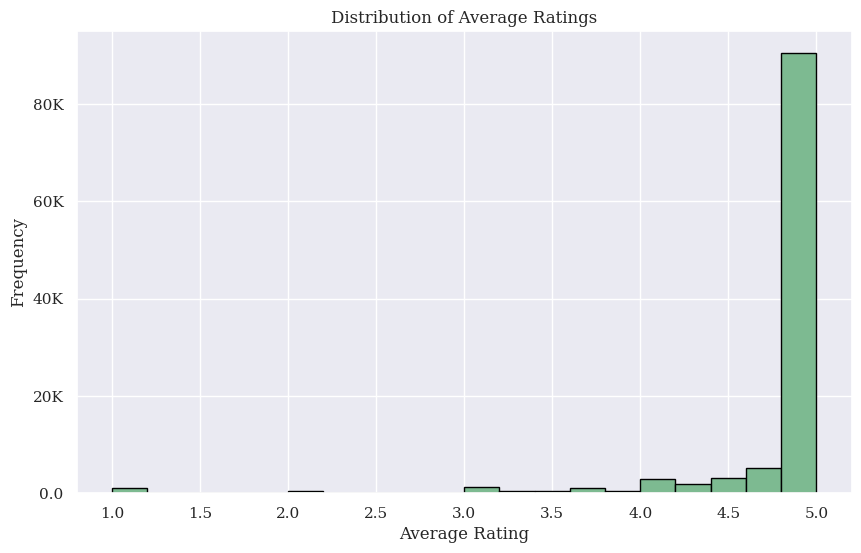

In [18]:

# viusalize the distribution of the avg_rating columns 
plt.figure(figsize=(10, 6))
plt.hist(top_10_podcasts['avg_rating'], bins=20, edgecolor='black')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Average Ratings')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_yticks))

plt.show()


First of all, we notice that many of the podcasts here were also among those who had the highest increase in review counts. Meaning popular podcasts only got more popular. Then we also see in the distribution of average ratings for podcasts, that the average ratings are extremely skewed toward 4.8 and higher.

Let's see which is the highest rated podcast. This might obtain very interesting results as we have just seen, so let's make sure that the number of reviews is substantial to confirm it's a popular one. 

We will opt for a minimum of 5000 reviews. 

In [19]:
top_rated_podcast = pd.read_sql("""
SELECT
   p.title,
   AVG(r.rating) AS avg_rating,
   COUNT(r.podcast_id) as review_count 
FROM
   podcasts p 
   LEFT JOIN
      reviews r 
      ON p.podcast_id = r.podcast_id 
GROUP BY
   p.title 
HAVING
   COUNT(r.podcast_id) > 5000 
ORDER BY
   avg_rating DESC LIMIT 1;
""", conn)   

top_rated_podcast

,title,avg_rating,review_count
0,Know Your Aura with Mystic Michaela,4.983594,5059


We can also check the most active reviewer in all of the dataset. We will use window functions here to make sure to catch the most active reviewers, and if there's two with the same number of reviews, they will get the same rank due to the DENSE_RANK() function.

In [20]:
top_reviewer = pd.read_sql("""
SELECT
   author_id,
   COUNT(*) AS review_count,
   DENSE_RANK () OVER (
ORDER BY
   COUNT(*) DESC) AS rank 
FROM
   reviews 
GROUP BY
   author_id 
ORDER BY
   review_count DESC LIMIT 10;
-- Top 10 most active reviewers
""", conn)

top_reviewer

,author_id,review_count,rank
0,D3307ADEFFA285C,615,1
1,791F376ACA3C08D,615,1
2,96A3F0358E7808D,475,2
3,04C3B6DEFE22FB1,433,3
4,8858ED4249110B6,399,4
5,7F9EA8B1A449BFC,361,5
6,4B25015E4D7A1DA,341,6
7,B20DB44F45DB97A,323,7
8,A52EBC918BC19D1,322,8
9,C02C514DAA9D885,314,9


There's 2 clear winners here, with 615 reviews posted. They both get the first place.

Let's check the various categories in which podcasts are present, to see if there is a correlation with the number of categories and their number of reviews.

In [21]:
categories_count = pd.read_sql("""
SELECT
   p.title,
   COUNT(r.podcast_id) AS review_count,
   COUNT(DISTINCT c.category) AS category_count 
FROM
   podcasts p 
   JOIN
      categories c 
      ON p.podcast_id = c.podcast_id 
   JOIN
      reviews r 
      ON p.podcast_id = r.podcast_id 
GROUP BY
   p.title 
HAVING
   category_count > 6
ORDER BY
   category_count
""", conn)

categories_count

,title,review_count,category_count
0,Am I Doing This Right?,107,7
1,Be a Better Lawyer hosted by Dina Cataldo,147,7
2,Betches Brides,4676,7
3,BrentonOnTour,49,7
4,Catching Up,172,7
5,Checking In,135,7
6,Cultivating the Lovely,1638,7
7,DOtheDamnWORK - The 'No More Excuses' Lifestyle,35,7
8,From the Field,60,7
9,Her Executive Presence,63,7


In [22]:
# check if there's a correlation
print_corr_matrix(categories_count, method='kendall')


,review_count,category_count
review_count,1.00,-0.11
category_count,-0.11,1.00


We can see how there's no relationship, and the little there is between the two variables infers one of the variables negatively influencing the other.

Now let's say we are interested in calculating the time gap between reviews, and want to get the top 10 for longest and shortest gap.

In [23]:
longest_review_gap = pd.read_sql("""
WITH ReviewGaps AS 
(
   SELECT
      r.podcast_id,
      p.title,
      r.created_at,
      LAG(r.created_at) OVER (PARTITION BY r.podcast_id 
   ORDER BY
      r.created_at) AS prev_review_time 
   FROM
      reviews r 
      JOIN
         podcasts p 
         ON r.podcast_id = p.podcast_id 
)
SELECT
   podcast_id,
   title,
   AVG(julianday(created_at) - julianday(prev_review_time)) AS avg_gap_days,
   (
      SELECT
         AVG(rating) 
      FROM
         reviews r 
      WHERE
         r.podcast_id = ReviewGaps.podcast_id
   )
   AS avg_rating 
FROM
   ReviewGaps 
WHERE
   prev_review_time IS NOT NULL 
GROUP BY
   podcast_id,
   title 
ORDER BY
   avg_gap_days
LIMIT 10;
-- Top 10 podcasts with the longest average gap between reviews
""", conn)

longest_review_gap

,podcast_id,title,avg_gap_days,avg_rating
0,e30c701bb5825ac002f5e23886b8b9f6,Indie Living Room,0.000000,5.0
1,e3b08ab63c9f28a5cf8a3d08d2220a99,Under The Covers,0.000000,5.0
2,ecd6da0b428af4b3ad9c19def79b61a1,Insights and Updates - The Literacy Bug,0.000000,4.0
3,f75c45a294bee499d088ccc4215eef5a,"Hey Mum, what’re you watching?",0.000000,5.0
4,f7ced17d4648cd4d6b34bf36470fd4b3,Los Indecisos,0.000012,5.0
5,c6a1bfc49f3e626216b5e352e0297f59,"Walking by Faith Podcast: Where marriage, mini...",0.000023,5.0
6,fd0db592170bb10ce4efe43ad2bc25f1,QUESTIONED AUTHORITY,0.000023,5.0
7,eafc00673398c394edf25b2eba89662e,Conspiracy Talk,0.000035,5.0
8,d65c6dbc653d549d858a60280b82e8b9,Cougar Nation Sports Weekly,0.000046,5.0
9,cdf3337d36a826ac3a2d9efb331daf9c,Particle,0.000058,5.0


In [24]:
shortest_review_gap = pd.read_sql_query("""
WITH ReviewGaps AS 
(
   SELECT
      r.podcast_id,
      p.title,
      r.created_at,
      LAG(r.created_at) OVER (PARTITION BY r.podcast_id 
   ORDER BY
      r.created_at) AS prev_review_time 
   FROM
      reviews r 
      JOIN
         podcasts p 
         ON r.podcast_id = p.podcast_id 
)
SELECT
   podcast_id,
   title,
   AVG(julianday(created_at) - julianday(prev_review_time)) AS avg_gap_days,
   (
      SELECT
         AVG(rating) 
      FROM
         reviews r 
      WHERE
         r.podcast_id = ReviewGaps.podcast_id
   )
   AS avg_rating 
FROM
   ReviewGaps 
WHERE
   prev_review_time IS NOT NULL 
GROUP BY
   podcast_id,
   title 
ORDER BY
   avg_gap_days DESC LIMIT 10;
-- Top 10 podcasts with the longest average gap between reviews
""", conn)

shortest_review_gap

,podcast_id,title,avg_gap_days,avg_rating
0,f6d781483e7fa40d43aa527254927663,Dr. Alan Cairns on SermonAudio,5290.944780,5.0
1,fdc13d932e5e7560aa213a16c5331295,Remix podcast from Magnatune.com,4964.536586,1.5
2,b66a47cc1c53e9c360b1e8ee1080d99e,Texas Corners Bible Church,4602.742731,5.0
3,a4987765263442032f293dcdf93e488c,Crime Fighters,4487.748958,3.5
4,c4a4ce8be06ec5ed358e4d97b5470c49,Country Music Cast,4325.018681,3.0
5,e7b09c856c458dc08573ea806f155a8b,Teacher's Pet Podcast - Training Pets & Pet Ob...,4219.153692,5.0
6,a7b02498b80812303f29944bd777a0b1,Health Report - Full program podcast,4215.330220,5.0
7,dcd9480725027d7fac9e8c24d286a397,House Junkee Podcast,4149.584294,5.0
8,a295413f283c7d163cfe72c962c79ef9,Indie Rock Baseball,4135.929850,5.0
9,e6b9ecf4cc71e1d98c62992d21257d0c,Mathematical Moments from the American Mathema...,4116.464630,4.5


# Statistical Inference

We want to create an A/B test, we want to test a simple hypothesis:

-   The podcasts with more positive sentiment in their review receive higher average ratings than podcasts with negative sentiment reviews.

To do so, and avoid biases (or p-hacking, HARKing, and so on) we will outline the steps required and proceed with them:

-   Define the hypothesis: 
    -   Null Hypothesis (H0): There is no significant difference in the average rating between positive and negative sentiment reviews.
    -   Alternative Hypothesis (H1): There is a significant difference in the average rating between positive and negative sentiment reviews.

-   Data Preparation:
    -   Split your dataset into groups: negative, positive and neutral sentiments.
    -   Compute the average review ratings for each group.

-   Statistical Test:
    -   We could use t-tests to easily compare these two differences, but we have technological tools at our disposal. Therefore, we will use bootstrapping to compare the two averages.
    -   The significance level (or alpha) used here will be of 0,05. Below this, we will consider the results of this sample not attributable to chance, and accept the alternative hypothesis.
    -   If the above is true, and we accept the alternative hypothesis, we will also check the effect size and confidence interval.

-   Visualization:
    -   The results of our AB test will be presented in a table or graph.



In [25]:
ab_test_df = pd.read_sql_query("""
WITH PodcastReviews AS (
    SELECT
        p.title AS podcast_title,
        r.title AS review_title,
        r.content AS review_content,
        r.author_id,
        r.created_at AS review_created_at,
        r.rating AS review_rating
    FROM
        podcasts p
    JOIN
        reviews r ON p.podcast_id = r.podcast_id
)
SELECT
    pr.podcast_title,
    pr.review_title,
    pr.review_content,
    pr.author_id,
    pr.review_created_at,
    AVG(pr.review_rating) AS avg_review_rating,
    p.avg_rating AS effective_avg_rating
FROM
    PodcastReviews pr
JOIN (
    SELECT
        p.title AS podcast_title,
        AVG(r.rating) AS avg_rating
    FROM
        podcasts p
    JOIN
        reviews r ON p.podcast_id = r.podcast_id
    GROUP BY
        p.title
) p ON pr.podcast_title = p.podcast_title
GROUP BY
    pr.podcast_title, pr.review_title, pr.review_content, pr.author_id, pr.review_created_at, p.avg_rating
ORDER BY
    pr.review_created_at;
""", conn)

ab_test_df


,podcast_title,review_title,review_content,author_id,review_created_at,avg_review_rating,effective_avg_rating
0,Drink 'til We're Funny!,my favorite queer podcast,I've spent a lot of time searching for enterta...,B2DF6EF08E9D7A1,2005-12-09T21:41:01-07:00,5.0,4.772727
1,Democracy Now! Audio,Jackpot!!!,Suddenly having on-demand access to the entire...,220D52F1492D8B4,2005-12-09T23:39:45-07:00,5.0,4.439024
2,Distorted View Daily,Awesomely funny and unique podcast,This is a well done and very enjoyable podcast...,65655C518D2D0CC,2005-12-10T09:19:30-07:00,5.0,4.785536
3,Insight for Living Daily Broadcast,Strong messages,Chuck Swindoll's Insight for Living. Has alway...,F7EC34F784D62EE,2005-12-10T11:06:38-07:00,5.0,4.664634
4,Eat This Hot Show,Eat This Hot Review,5 Stars for you! One Of The Best On itunes.,BC3DD2C1DE0AEE3,2005-12-10T15:10:25-07:00,5.0,4.468750
...,...,...,...,...,...,...,...
2042644,For the Love of Freelance,I will be binging!,Just found this podcast and I already plan to ...,EE7877B6C336602,2023-02-16T08:15:52-07:00,5.0,5.000000
2042645,Ruthless,One Driver at a Time!!,You guys nailed it again! Hilarious episode to...,D7377DCBB0E3A68,2023-02-16T08:24:59-07:00,5.0,4.666181
2042646,True Crime with Kendall Rae,Another Anti-Police host,This one actually says…”it was as if the polic...,096A4B476F3C011,2023-02-16T08:38:37-07:00,1.0,4.136531
2042647,The Joe Rogan Experience,NEWS RADIO FAN 4 life,"Joe is my source for Honest, Hard Hitting Com...",3BBAB440E06A8CB,٢٠٢٠-١٢-٢٤T٠٨:٢٦:٣٦-07:00,5.0,3.737408


In [29]:
# save the dataframe to pickl ein folder df_folder
ab_test_df.to_pickle(path=f"{df_folder}/ab_test_df.pkl")